# About / Goal

This notebook explores public sentiment around the war in Ukraine using recent English-language tweets from X (Twitter). The aim is to build an end-to-end, reproducible pipeline: data collection → text preprocessing → model-based sentiment analysis → comparison of two classifiers → visualization and interpretation.

**What this notebook shows**
- A “full” sentiment analysis using transformer models (no keyword heuristics).
- Two models compared: DistilBERT (2 classes: negative/positive) and CardiffNLP (3 classes: negative/neutral/positive).
- Agreement metrics and clean visual summaries.

**Scope & limitations**
- Recent tweets only (API access limits); English language to start.
- No geolocation or bot filtering; results reflect a sample, not the full population.
- Model outputs depend on training data and may misread sarcasm or ambiguous news-style text.

**Outcome**
- A clear baseline for sentiment tracking on this topic, ready to extend with bigger samples, multilingual models, confidence filtering, and time-based trends.


### Step 1. Data download from X (Twitter)

In [ ]:
import tweepy
import pandas as pd

# --- Authentication with Twitter API ---
bearer_token = ""  
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

# --- Define search query ---
query = "Ukraine (peace OR ceasefire OR negotiations OR attack OR escalation) -is:retweet lang:en"

# --- Search recent tweets ---
tweets = client.search_recent_tweets(
    query=query,
    tweet_fields=["id", "text", "created_at", "lang"],  
    max_results=50  
)

# --- Store new results in DataFrame ---
data = []
if tweets.data:  
    for tweet in tweets.data:
        data.append({
            "id": tweet.id,
            "text": tweet.text,
            "created_at": tweet.created_at,
            "lang": tweet.lang
        })

new_df = pd.DataFrame(data)

# --- Try to read old CSV and append new data ---
try:
    old_df = pd.read_csv("tweets_ukraine_en.csv")
    df = pd.concat([old_df, new_df]).drop_duplicates(subset=["id"])
except FileNotFoundError:
    df = new_df

# --- Show updated DataFrame ---
display(df.head())
print(f"Liczba obserwacji w pliku: {len(df)}")

# --- Save updated DataFrame ---
df.to_csv("tweets_ukraine_en.csv", index=False)


Rate limit exceeded. Sleeping for 902 seconds.


In [1]:
import pandas as pd

df = pd.read_csv("tweets_ukraine_en.csv")
df = df.reset_index(drop=True)
df.tail(20)

,id,text,created_at,lang
91,1968380131648397583,"German Chancellor Merz promised that ""after Uk...",2025-09-17 18:22:48+00:00,en
92,1968390076762833040,legal instruments available could be game chan...,2025-09-17 19:02:19+00:00,en
93,1968389641947726305,"Whoops, seems Lavrov slipped up again.\n\nHe s...",2025-09-17 19:00:36+00:00,en
94,1968389584238080074,The 1944 Finnish-Soviet armistice is more rele...,2025-09-17 19:00:22+00:00,en
95,1968389571625836714,"#UkraineAlert | ""As peace negotiations continu...",2025-09-17 19:00:19+00:00,en
96,1968389244466119163,@juth Fox News Reporter Feels ‘Damn Lucky’ Aft...,2025-09-17 18:59:01+00:00,en
97,1968389127805759656,"@DakdaR22 So, if Russia doesn’t want to attack...",2025-09-17 18:58:33+00:00,en
98,1968388772212683173,"Russian distrust of NATO, whether under NATO f...",2025-09-17 18:57:08+00:00,en
99,1968388731343417706,@Stepan411560 @pipka6666 @kava220 @asbatura88 ...,2025-09-17 18:56:59+00:00,en
100,1968387881778692225,@WakeUpPatriott B because I am sure Ukraine wi...,2025-09-17 18:53:36+00:00,en


### Step 2. Text preprocessing

In [2]:
import re

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (just the #, keep the word if you want)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to your DataFrame
df["clean_text"] = df["text"].apply(clean_tweet)

# Show a preview
display(df[["text", "clean_text"]].head())

,text,clean_text
0,@GeneralpattonS Under the guise of a peace tre...,under the guise of a peace treatysounds like w...
1,"@RapidResponse47 @VP Hey Vance, why are grocer...",hey vance why are grocery prices still high wh...
2,King Charles III stepping up for Ukraine peace...,king charles iii stepping up for ukraine peace...
3,OPINION: A European force in postwar Ukraine i...,opinion a european force in postwar ukraine is...
4,If this is true it’s a shocker. Kozak is Putin...,if this is true its a shocker kozak is putin l...


### Step 3. Sentiment analysis

In [ ]:
from transformers import pipeline

# Load pre-trained sentiment analysis model
# This is an English model (default sentiment-analysis pipeline)
sentiment_model = pipeline("sentiment-analysis")

# Apply the model to our cleaned tweets
df["sentiment"] = df["clean_text"].apply(lambda x: sentiment_model(x)[0]["label"])
df["score"] = df["clean_text"].apply(lambda x: sentiment_model(x)[0]["score"])

# Show a preview
display(df[["clean_text", "sentiment", "score"]].head())


c:\Users\antek\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,clean_text,sentiment,score
0,under the guise of a peace treatysounds like w...,NEGATIVE,0.988349
1,hey vance why are grocery prices still high wh...,NEGATIVE,0.996856
2,king charles iii stepping up for ukraine peace...,POSITIVE,0.995017
3,opinion a european force in postwar ukraine is...,POSITIVE,0.997564
4,if this is true its a shocker kozak is putin l...,NEGATIVE,0.991596


In [4]:
from transformers import pipeline

# Load sentiment analysis model with 3 labels: negative, neutral, positive
sentiment_model_cardiff = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Apply the model to our cleaned tweets
df["sentiment_cardiff"] = df["clean_text"].apply(lambda x: sentiment_model_cardiff(x)[0]["label"])
df["score_cardiff"] = df["clean_text"].apply(lambda x: sentiment_model_cardiff(x)[0]["score"])

# Show a preview
display(df[["clean_text", "sentiment_cardiff", "score_cardiff"]].head())


c:\Users\antek\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\antek\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is

,clean_text,sentiment_cardiff,score_cardiff
0,under the guise of a peace treatysounds like w...,negative,0.677394
1,hey vance why are grocery prices still high wh...,negative,0.889011
2,king charles iii stepping up for ukraine peace...,positive,0.594371
3,opinion a european force in postwar ukraine is...,positive,0.793708
4,if this is true its a shocker kozak is putin l...,negative,0.777692


### Step 4. Results aggregation and comparison

In [5]:
import pandas as pd

# Count sentiment distribution for each model
distil_counts = df["sentiment"].value_counts(normalize=True) * 100
cardiff_counts = df["sentiment_cardiff"].value_counts(normalize=True) * 100

print("DistilBERT sentiment distribution (%):")
print(distil_counts.round(2))
print("\nCardiffNLP sentiment distribution (%):")
print(cardiff_counts.round(2))

# Compare first few rows side by side
display(df[["clean_text", "sentiment", "sentiment_cardiff"]].head(10))


DistilBERT sentiment distribution (%):
sentiment
NEGATIVE    77.48
POSITIVE    22.52
Name: proportion, dtype: float64

CardiffNLP sentiment distribution (%):
sentiment_cardiff
negative    60.36
neutral     26.13
positive    13.51
Name: proportion, dtype: float64


,clean_text,sentiment,sentiment_cardiff
0,under the guise of a peace treatysounds like w...,NEGATIVE,negative
1,hey vance why are grocery prices still high wh...,NEGATIVE,negative
2,king charles iii stepping up for ukraine peace...,POSITIVE,positive
3,opinion a european force in postwar ukraine is...,POSITIVE,positive
4,if this is true its a shocker kozak is putin l...,NEGATIVE,negative
5,you are really sick in russophrenia which is n...,NEGATIVE,negative
6,german chancellor merz warns putin is sabotagi...,NEGATIVE,negative
7,whats this about tesla and reuters and covid a...,NEGATIVE,negative
8,a radar system was damaged in a drone attack i...,NEGATIVE,negative
9,of ukrainians support the europeukraine peace ...,POSITIVE,positive


### Step 5. Visualization

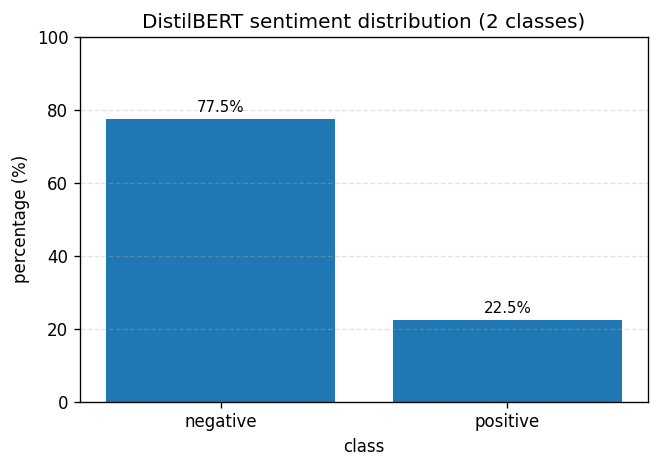

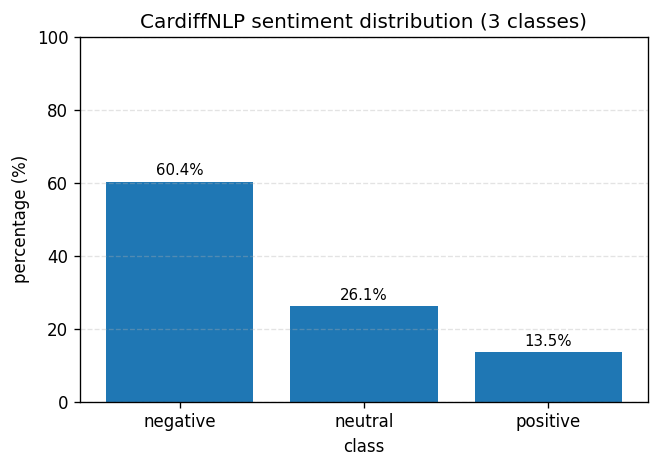

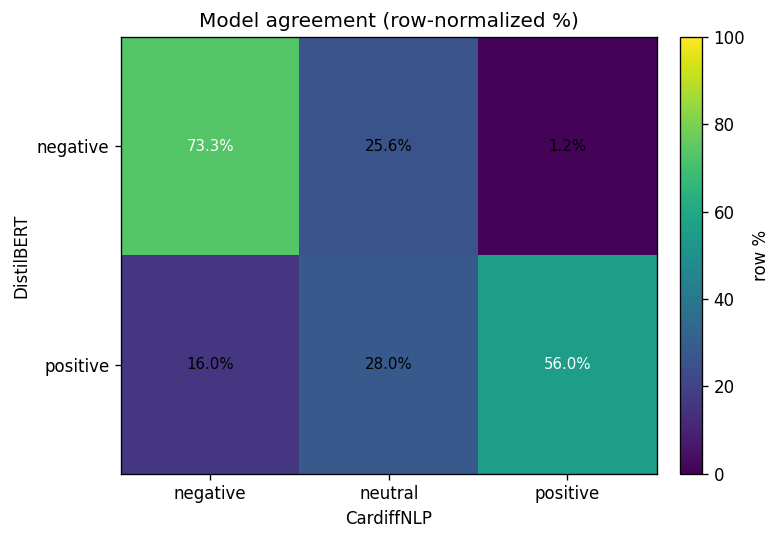

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df["sentiment"] = df["sentiment"].str.lower()
df["sentiment_cardiff"] = df["sentiment_cardiff"].str.lower()

# 1) Distributions (simple, clean)
def plot_distribution(series, order, title):
    pct = series.value_counts(normalize=True).reindex(order, fill_value=0).mul(100)
    plt.figure(figsize=(5.6, 4.0))
    bars = plt.bar(pct.index, pct.values)
    plt.ylim(0, max(100, pct.max() + 10))
    plt.title(title)
    plt.xlabel("class")
    plt.ylabel("percentage (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    # labels on bars
    for b, v in zip(bars, pct.values):
        plt.text(b.get_x() + b.get_width()/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

plot_distribution(df["sentiment"], ["negative", "positive"],
                  "DistilBERT sentiment distribution (2 classes)")
plot_distribution(df["sentiment_cardiff"], ["negative", "neutral", "positive"],
                  "CardiffNLP sentiment distribution (3 classes)")

# 2) Agreement heatmap (row-normalized %) 
distil_order  = ["negative", "positive"]               
cardiff_order = ["negative", "neutral", "positive"]      

ct = pd.crosstab(df["sentiment"], df["sentiment_cardiff"])\
       .reindex(index=distil_order, columns=cardiff_order, fill_value=0)

ct_pct = ct.div(ct.sum(axis=1), axis=0).mul(100)  

plt.figure(figsize=(6.6, 4.6))
im = plt.imshow(ct_pct.values, aspect="auto", vmin=0, vmax=100)
plt.colorbar(im, fraction=0.046, pad=0.04, label="row %")

plt.xticks(np.arange(len(cardiff_order)), cardiff_order)
plt.yticks(np.arange(len(distil_order)), distil_order)
plt.title("Model agreement (row-normalized %)")

for i in range(ct_pct.shape[0]):
    for j in range(ct_pct.shape[1]):
        val = ct_pct.iat[i, j]
        plt.text(j, i, f"{val:.1f}%", ha="center", va="center",
                 color="white" if val > 55 else "black", fontsize=9)

plt.xlabel("CardiffNLP")
plt.ylabel("DistilBERT")
plt.tight_layout()
plt.show()


### Step 6. Interpretation and quality checks

In [12]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Keep only rows where CardiffNLP is not neutral
mask_bin = df["sentiment_cardiff"].str.lower().isin(["negative", "positive"])
bin_df = df[mask_bin].copy()

# Lowercase for safety
bin_df["distil_bin"] = bin_df["sentiment"].str.lower()
bin_df["cardiff_bin"] = bin_df["sentiment_cardiff"].str.lower()

# Basic agreement
agreement_rate = (bin_df["distil_bin"] == bin_df["cardiff_bin"]).mean()

# Cohen’s kappa (chance-corrected agreement)
kappa = cohen_kappa_score(bin_df["distil_bin"], bin_df["cardiff_bin"])

print(f"Binary agreement (no 'neutral'): {agreement_rate:.3f}")
print(f"Cohen's kappa: {kappa:.3f}")

Binary agreement (no 'neutral'): 0.939
Cohen's kappa: 0.811


In [13]:
# Disagreements between models (ignore neutral)
disagreements = bin_df[bin_df["distil_bin"] != bin_df["cardiff_bin"]]

# Show a few examples sorted by Cardiff's confidence (low to high)
cols = ["text", "clean_text", "sentiment", "score", "sentiment_cardiff", "score_cardiff"]
display(disagreements.sort_values("score_cardiff").head(10)[cols])

# Low-confidence predictions (both models uncertain)
low_conf = df[(df["score"] < 0.7) | (df["score_cardiff"] < 0.7)]
display(low_conf.sort_values(["score_cardiff", "score"]).head(10)[cols])

,text,clean_text,sentiment,score,sentiment_cardiff,score_cardiff
92,legal instruments available could be game chan...,legal instruments available could be game chan...,negative,0.988135,positive,0.505654
91,"German Chancellor Merz promised that ""after Uk...",german chancellor merz promised that after ukr...,positive,0.799389,negative,0.515770
64,Hi Fellas! Please stay on task and do not get ...,hi fellas please stay on task and do not get p...,positive,0.987554,negative,0.588683
70,@sashafrp @Defence_Index I don’t want to attac...,i dont want to attack i want russia to stop il...,positive,0.541432,negative,0.704958
63,"It’s like our country is under attack, possibl...",its like our country is under attack possibly ...,positive,0.967055,negative,0.898717


,text,clean_text,sentiment,score,sentiment_cardiff,score_cardiff
96,@juth Fox News Reporter Feels ‘Damn Lucky’ Aft...,fox news reporter feels damn lucky after losin...,negative,0.628559,neutral,0.462527
30,@justyoung01 @redeemed_zoomer Using all that f...,using all that freedom and liberty to attack t...,positive,0.998252,neutral,0.488437
74,@ZelenskyyUa The only country who can provide ...,the only country who can provide and assuring ...,negative,0.999329,neutral,0.496354
50,@ZelenskyyUa @ZelenskaUA @AndriyYermak @Defenc...,russia attack romania before go ask them,negative,0.995898,negative,0.499689
9,2. 74% of Ukrainians support the Europe-Ukrain...,of ukrainians support the europeukraine peace ...,positive,0.810889,positive,0.499754
84,@perteng1 @mtmalinen @ZelenskyyUa You want to ...,you want to say that for ukraine to achieve pe...,negative,0.995018,negative,0.505611
92,legal instruments available could be game chan...,legal instruments available could be game chan...,negative,0.988135,positive,0.505654
26,The president @realDonaldTrump recently said t...,the president recently said that he believed h...,positive,0.973243,positive,0.508227
91,"German Chancellor Merz promised that ""after Uk...",german chancellor merz promised that after ukr...,positive,0.799389,negative,0.515770
48,@Maks_NAFO_FELLA While there are still Nazi-Ru...,while there are still naziruzzian sympathizers...,negative,0.915813,neutral,0.523180


**Interpretation**

Both models tell a similar story on clearly polar tweets: ~94% raw agreement and Cohen’s κ ≈ 0.81 (“almost perfect”). CardiffNLP is more conservative and often assigns *neutral* where DistilBERT picks *positive*, especially for factual/mixed statements or low-confidence cases. I will use CardiffNLP (neg/neu/pos) as the primary signal and keep DistilBERT as a robustness check; filtering by higher confidence (e.g., ≥ 0.75) should improve reliability.
